In [1]:
# Import libraries
%%capture
import json
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings
import statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
from regression_helper_functions_03 import ts_data
warnings.filterwarnings('ignore')

### Data Preperation

In [2]:
df = pd.read_excel('small_db_prepared_mod.xlsx')
df.datehour = pd.DatetimeIndex(df.datehour)

In [3]:
df['weekday'] = df['datetime'].dt.weekday

In [4]:
df.head(2)

,Unnamed: 0,index,category,doctorID,patientID,timestamp,datetime,date,year-month,month,day,hour,hour_mod,datehour,country,weekday
0,0,-LqasdO-N-o9ML5M3ICA,No Category,y4fUyodWbGRQSiFlwOUfdK0crmE2,NApxH0YKcMbae7pP375QhuM6GIk2,1570462930530,2019-10-07 15:42:10.530,2019-10-07,2019-10,10,7,15,15:00:00,2019-10-07 15:00:00,CA,0
1,1,-Lqb3SQnkErOkNxDND4d,No Category,YhgZleDQo1SwlK6gCAspRSdB89z2,NApxH0YKcMbae7pP375QhuM6GIk2,1570466027280,2019-10-07 16:33:47.280,2019-10-07,2019-10,10,7,16,16:00:00,2019-10-07 16:00:00,CA,0


### Total #. of chats per country

In [5]:
totalVolumeCountry = df.groupby(['country','datehour']).agg({'patientID':'nunique'}).sort_values(by='patientID', ascending=False).reset_index()
totalVolumeCountry = totalVolumeCountry.groupby(['country']).agg({'patientID':'sum'}).sort_values(by='patientID', ascending=False).reset_index()
totalVolumeCountry.head(10)

,country,patientID
0,US,16446
1,BLANK,3300
2,GB,3177
3,CA,2788
4,AU,754
5,SG,346
6,PH,318
7,PK,284
8,NL,189
9,IE,186


In [6]:
len(totalVolumeCountry)

141

In [7]:
totalVolumeCountry.tail(10)

,country,patientID
131,BW,1
132,AZ,1
133,TC,1
134,SX,1
135,BN,1
136,BM,1
137,BI,1
138,DO,1
139,KG,1
140,GE,1


### Total #. of chats requested per year-month

In [8]:
totalVolume = df.groupby(['country','year-month','date','hour']).agg({'patientID':'nunique'}).reset_index()
totalVolume.head()

,country,year-month,date,hour,patientID
0,AE,2019-10,2019-10-12,18,1
1,AE,2019-10,2019-10-19,7,1
2,AE,2019-10,2019-10-19,14,1
3,AE,2019-10,2019-10-19,17,1
4,AE,2019-10,2019-10-19,18,1


In [9]:
totalVolume = totalVolume.groupby(['country','year-month']).agg({'patientID':'sum'}).reset_index()
totalVolume = totalVolume.pivot(index='year-month', columns='country', values='patientID').reset_index()
totalVolume.head()

country,year-month,AE,AF,AG,AI,AL,AM,AR,AT,AU,...,UG,US,UY,VI,VN,VU,XK,YE,ZA,ZM
0,2019-10,18.0,NaN,4.0,NaN,2.0,1.0,NaN,NaN,38.0,...,NaN,760.0,NaN,NaN,NaN,NaN,NaN,NaN,21.0,NaN
1,2019-11,23.0,6.0,4.0,NaN,1.0,NaN,NaN,3.0,78.0,...,NaN,1204.0,NaN,4.0,2.0,NaN,NaN,NaN,8.0,2.0
2,2019-12,25.0,7.0,2.0,NaN,2.0,NaN,NaN,1.0,74.0,...,5.0,1482.0,NaN,2.0,NaN,NaN,NaN,NaN,32.0,NaN
3,2020-01,31.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,112.0,...,NaN,1917.0,NaN,1.0,3.0,1.0,NaN,NaN,38.0,1.0
4,2020-02,26.0,1.0,1.0,NaN,1.0,NaN,2.0,5.0,129.0,...,NaN,2200.0,NaN,4.0,2.0,NaN,1.0,NaN,28.0,NaN


In [10]:
totalVolume.replace(np.nan,0)
totalVolume['Entire'] = totalVolume.iloc[:,2:].sum(axis=1)

In [11]:
totalVolume = totalVolume[['year-month','Entire','US','GB','CA']].set_index('year-month')

In [12]:
totalVolume

country,Entire,US,GB,CA
year-month,,,,
2019-10,1525.0,760.0,211.0,207.0
2019-11,2878.0,1204.0,406.0,249.0
2019-12,2941.0,1482.0,390.0,323.0
2020-01,3608.0,1917.0,439.0,325.0
2020-02,4226.0,2200.0,475.0,325.0
2020-03,5181.0,3105.0,398.0,445.0
2020-04,6166.0,3758.0,511.0,461.0
2020-05,3919.0,2020.0,347.0,453.0


##### Total #. of chats requested per year-month for the top 3 countries

(array([   0., 1000., 2000., 3000., 4000., 5000.]),
 <a list of 6 Text yticklabel objects>)

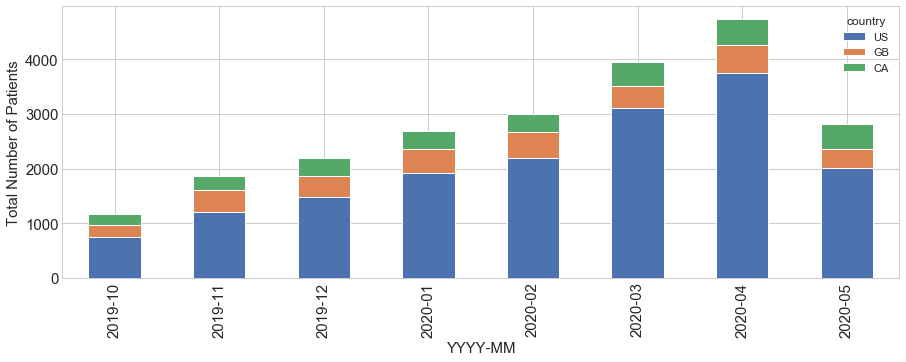

In [13]:
sns.set()
plt.style.use('seaborn-whitegrid')
totalVolume.loc[:,['US', 'GB', 'CA']].plot.bar(stacked=True, figsize=(15,5))
plt.ylabel('Total Number of Patients',fontsize=15)
plt.xlabel('YYYY-MM',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

##### Total #. of chats requested per year-month considering the entire dataset

(array([   0., 1000., 2000., 3000., 4000., 5000., 6000., 7000.]),
 <a list of 8 Text yticklabel objects>)

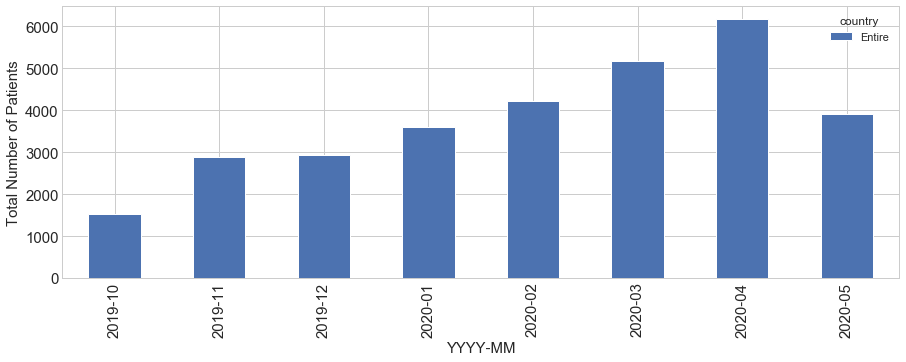

In [14]:
sns.set()
plt.style.use('seaborn-whitegrid')
totalVolume.loc[:,['Entire']].plot.bar(stacked=True, figsize=(15,5))
plt.ylabel('Total Number of Patients',fontsize=15)
plt.xlabel('YYYY-MM',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

### Average #. of chats per hour

In [15]:
# admin[length_of_stay] = admin[]
hourlyVolume = df.groupby(['country','weekday','date','hour']).agg({'patientID':'nunique'}).reset_index()
hourlyVolume = hourlyVolume.groupby(['country','hour']).agg({'patientID':'mean'}).reset_index()

In [16]:
hourlyVolume_ENTIRE = hourlyVolume.groupby(['hour']).agg({'patientID':'mean'}).reset_index()
hourlyVolume_US = hourlyVolume[hourlyVolume['country']=='US']
hourlyVolume_GB = hourlyVolume[hourlyVolume['country']=='GB']
hourlyVolume_CA = hourlyVolume[hourlyVolume['country']=='CA']

In [17]:
sns.set()
plt.style.use('seaborn-whitegrid')

(-0.2, 24)

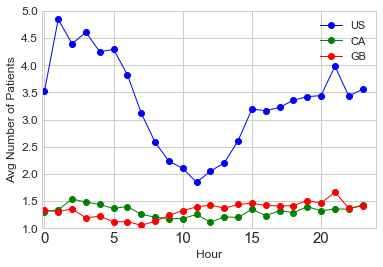

In [18]:
#hourlyVolume_CA.plot(x='hour',y='patientID',kind='line',figsize=(12,2))
plt.plot('hour', 'patientID', data=hourlyVolume_US, marker='o', color='blue', linewidth='1', label='US')
plt.plot('hour', 'patientID', data=hourlyVolume_CA, marker='o', color='green', linewidth='1', label='CA')
plt.plot('hour', 'patientID', data=hourlyVolume_GB, marker='o', color='red', linewidth='1', label='GB')
plt.rcParams["figure.figsize"] = (10,3)
plt.ylabel('Avg Number of Patients',fontsize=12)
plt.xlabel('Hour',fontsize=12)
plt.xticks(fontsize=15)
plt.yticks(fontsize=12)
plt.legend()
plt.ylim(1,5)
plt.xlim(-0.2,24)

### Total #. of chats per day in a week

In [19]:
weekdayVolume = df.groupby(['country','weekday','date','hour']).agg({'patientID':'nunique'}).reset_index()
weekdayVolume = weekdayVolume.groupby(['country','weekday']).agg({'patientID':'mean'}).reset_index()
weekdayVolume_US = weekdayVolume[weekdayVolume['country']=='US']
weekdayVolume_GB = weekdayVolume[weekdayVolume['country']=='GB']
weekdayVolume_CA = weekdayVolume[weekdayVolume['country']=='CA']

(1, 5)

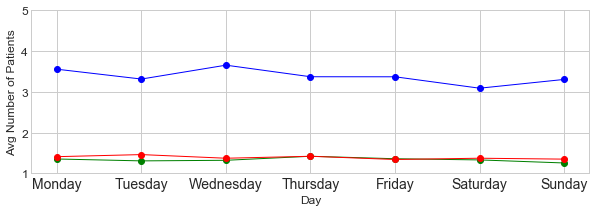

In [20]:
#weekdayVolume_CA.plot(x='weekday',y='patientID',kind='line',figsize=(12,2))
plt.plot('weekday', 'patientID', data=weekdayVolume_US, marker='o', color='blue', linewidth='1', label='US')
plt.plot('weekday', 'patientID', data=weekdayVolume_CA, marker='o', color='green', linewidth='1', label='CA')
plt.plot('weekday', 'patientID', data=weekdayVolume_GB, marker='o', color='red', linewidth='1', label='GB')

plt.ylabel('Avg Number of Patients',fontsize=12)
plt.xlabel('Day',fontsize=12)
positions = (0, 1, 2, 3, 4, 5, 6)
labels = ('Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday')
plt.xticks(positions, labels,fontsize=14)
plt.yticks(fontsize=12)
plt.legend('',frameon=False)
plt.ylim(1,5)

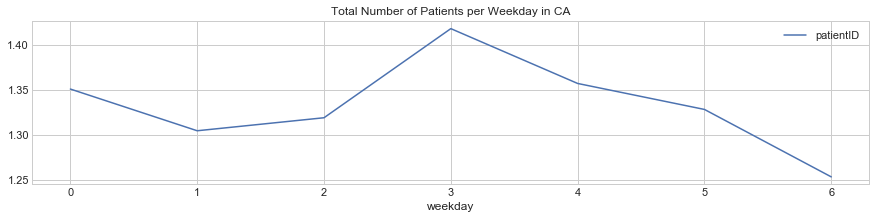

In [21]:
weekdayVolume_CA.plot(x='weekday',y='patientID',kind='line',title='Total Number of Patients per Weekday in CA',figsize=(15,3))


### Average #. of chats per category per day in a month for the top 3 countries

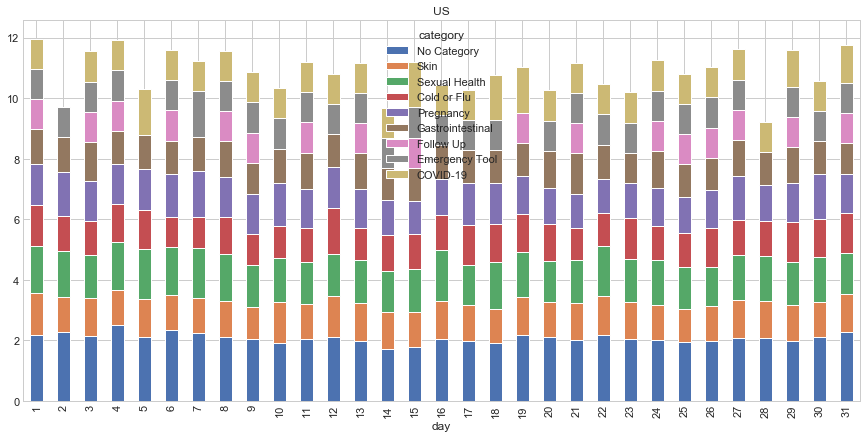

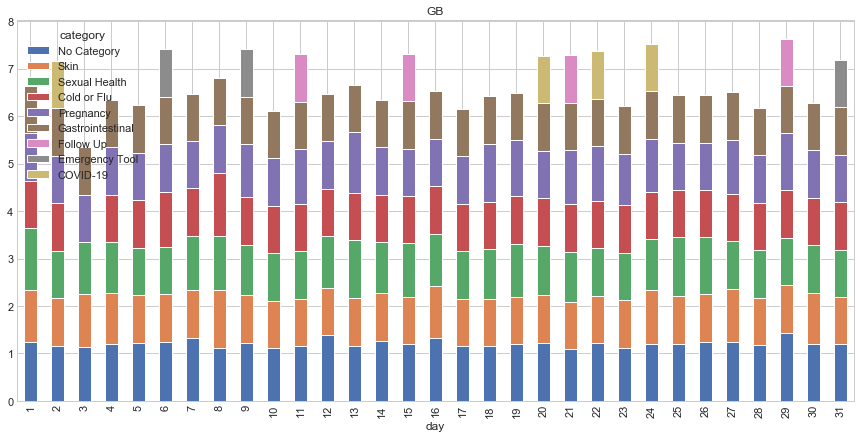

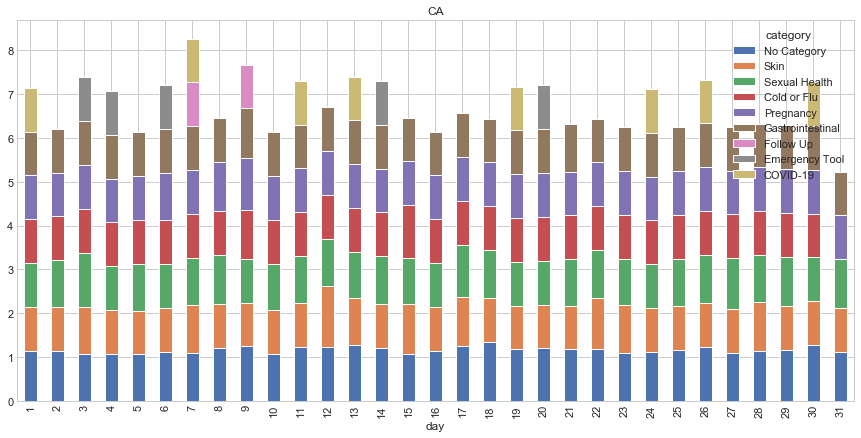

In [22]:
categoryVolume = df.groupby(['country','date','day','hour','category']).agg({'patientID':'nunique'}).reset_index()
#categoryVolume = df.groupby(['date','day','category']).agg({'patientID':'sum'}).reset_index()
c = ['US','GB','CA']
for i in range(0,3):
    country = c[i]
    catVol = categoryVolume[categoryVolume['country']==country]
    catVol = catVol.groupby(['day','category']).agg({'patientID':'mean'}).reset_index()
    catVol = catVol.pivot(index='day', columns='category', values='patientID')
    catVol.loc[:,['No Category', 'Skin', 'Sexual Health', 'Cold or Flu', 'Pregnancy',
       'Gastrointestinal', 'Follow Up', 'Emergency Tool', 'COVID-19']].plot.bar(stacked=True, title=country, figsize=(15,7))

- Average patient volume (chats) appears to be consistent among different categories

### Total #. of chats per category per year-month for the top 3 countries

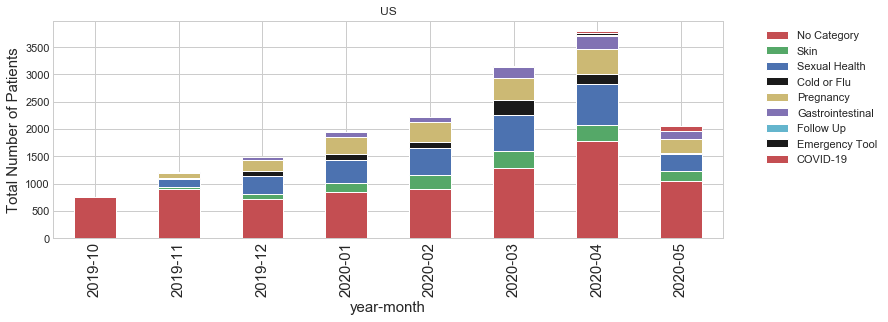

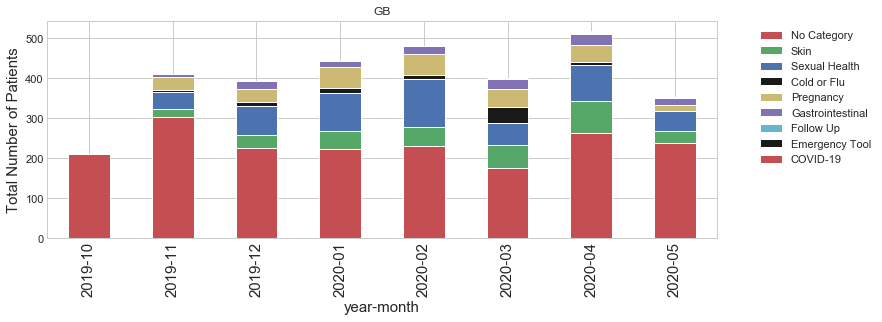

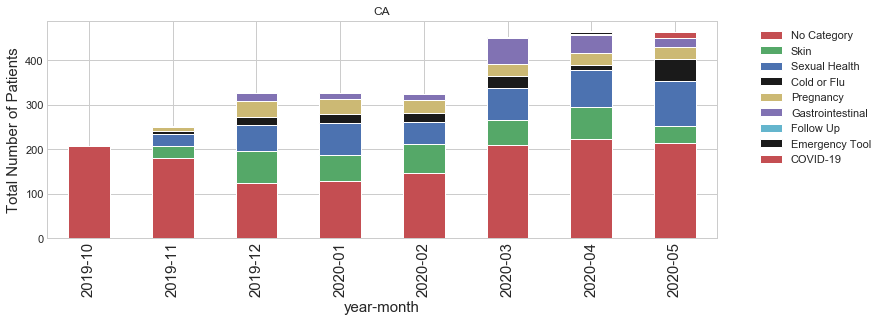

In [29]:
categoryVolume = df.groupby(['country','date','year-month','month','day','hour','category']).agg({'patientID':'nunique'}).reset_index()
c = ['US','GB','CA']


for i in range(0,3):
    country = c[i]
    catVol = categoryVolume[categoryVolume['country']==country]
    catVol = catVol.groupby(['year-month','category']).agg({'patientID':'sum'}).reset_index()
    catVol = catVol.pivot(index='year-month', columns='category', values='patientID')
    catVol = catVol.fillna(0)
    catVol.loc[:,['No Category', 'Skin', 'Sexual Health', 'Cold or Flu',
       'Pregnancy', 'Gastrointestinal', 'Follow Up', 'Emergency Tool',
       'COVID-19']].plot.bar(stacked=True, figsize=(12,4), title=country, color='rgbkymckr')
    plt.xticks(fontsize=15)
    plt.ylabel('Total Number of Patients',fontsize=15)
    plt.xlabel('year-month',fontsize=15)
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')


